(200, 2) (200, 1)


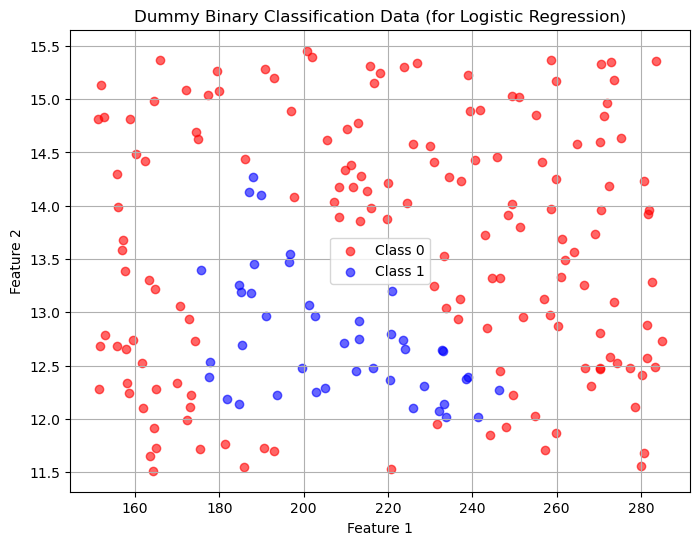

In [2]:
import numpy as np
from matplotlib import pyplot as plt

def load_coffee_data():
    """ Creates a coffee roasting data set.
        roasting duration: 12-15 minutes is best
        temperature range: 175-260C is best
    """
    rng = np.random.default_rng(2)
    x = rng.random(400).reshape(-1,2)
    x[:,1] = x[:,1] * 4 + 11.5          # 12-15 min is best
    x[:,0] = x[:,0] * (285-150) + 150  # 350-500 F (175-260 C) is best
    Y = np.zeros(len(x))
    
    i=0
    for t,d in x:
        y = -3/(260-175)*t + 21
        if (t > 175 and t < 260 and d > 12 and d < 15 and d<=y ):
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1

    return (x, Y.reshape(-1,1))

x,y = load_coffee_data()
print(x.shape, y.shape)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x[y.flatten() == 0][:, 0], x[y.flatten() == 0][:, 1], color="red", label="Class 0", alpha=0.6)
plt.scatter(x[y.flatten() == 1][:, 0], x[y.flatten() == 1][:, 1], color="blue", label="Class 1", alpha=0.6)
plt.title("Dummy Binary Classification Data (for Logistic Regression)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

0.00056015585563723
Min prediction: 7.124576406741285e-218
Max prediction: 1.0
Accuracy:  100.00%


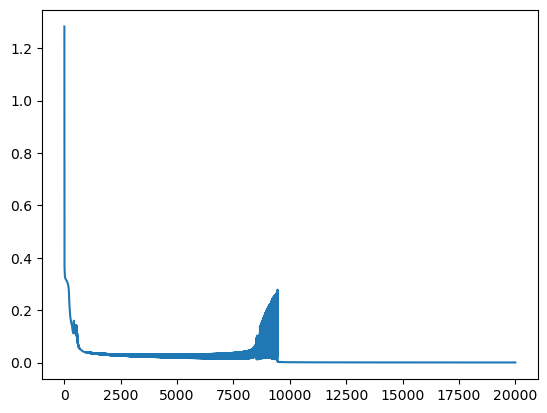

In [51]:
x_original = x.copy();
x_mean = np.mean(x,axis=0)
x_std = np.std(x,axis=0)
x = (x-x_mean)/x_std
x1 = x[:,0].reshape(-1,1)
x2 = x[:,1].reshape(-1,1)
def preprocess_input(x):
    x1 = x[:, 0].reshape(-1, 1)
    x2 = x[:, 1].reshape(-1, 1)
    return np.hstack((x1, x2))
x_original = x.copy();


def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1/(1+np.exp(-z))

def d_sigmoid(z):
    s = sigmoid(z)
    return s*(1-s)

def ReLU(z):
    return np.maximum(0,z)

def d_ReLU(z):
    return (z > 0).astype(float)

def dense(A_in,W,B,activation):
    Z = A_in@W+B
    if(activation == "ReLU"):
        A_out = ReLU(Z)
    elif(activation =="sigmoid"):
        A_out = sigmoid(Z)
    return Z,A_out

layers = [2,3,1]
activations = ["ReLU","sigmoid"]
np.random.seed(0)
lr = 1.36
w= []
for i in range(len(layers)-1):
     w.append(np.random.randn(layers[i], layers[i + 1]) * np.sqrt(2.0 / layers[i]))
                      
b = []
for i in range(len(layers)-1):
    b.append(np.zeros((1,layers[i+1])))

def sequential(x):
    a = x
    z_values = []
    a_values = [x]
    for i in range(len(w)):
        z,a = dense(a,w[i],b[i],activations[i])
        z_values.append(z)
        a_values.append(a)
    return z_values,a_values
def backward(y,z,a,lr):
    global w,b
    m = x.shape[0]
    L = len(w)
    dz = a[-1]-y
    for i in reversed(range(L)):
        a_prev = a[i]
        dw = (a_prev.T@dz)/m
        db = np.sum(dz,axis=0,keepdims=True)/m
        w[i] -= lr*dw
        b[i] -= lr*db
        if i>0:
            da = dz@w[i].T
            if(activations[i-1]=="ReLU"):
                dz = da * d_ReLU(z[i-1])
            elif(activations[i-1]=="sigmoid"):
                dz = da * d_sigmoid(z[i-1])

iteration = 20000
cost = []
for i in range(iteration):
    z,a = sequential(x)
    a_final = a[-1]
    epsilon = 1e-15
    a_final_clipped = np.clip(a_final, epsilon, 1 - epsilon)
    cst = -np.mean(y * np.log(a_final_clipped) + (1 - y) * np.log(1 - a_final_clipped))
    cost.append(cst)
    backward(y,z,a,lr)

def predict(x):
    x = preprocess_input(x)
    _,a_values = sequential(x)
    return a_values[-1]
print(cost[-1])
preds = predict(x)
print("Min prediction:", np.min(preds))
print("Max prediction:", np.max(preds))
binary_predictions = (preds >= 0.5).astype(int)
accuracy = np.mean(binary_predictions == y)
print(f"Accuracy:  {accuracy*100:.2f}%")
plt.plot(cost)
plt.show()


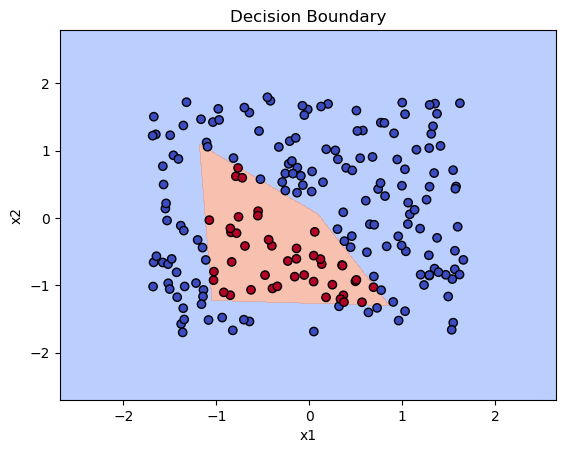

In [38]:
# Plot decision boundary
h = 0.01  # step size in the mesh

# Original x1 and x2
x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1

xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                       np.arange(x2_min, x2_max, h))

# Create input grid
grid_input = np.c_[xx1.ravel(), xx2.ravel()]
grid_input_processed = preprocess_input(grid_input)

# Predict for the entire grid
Z = predict(grid_input)
Z = Z.reshape(xx1.shape)

# Plot the contour and training points
plt.contourf(xx1, xx2, Z, levels=[0, 0.5, 1], cmap="coolwarm", alpha=0.6)
plt.scatter(x[:, 0], x[:, 1], c=y.ravel(), edgecolors='k', cmap="coolwarm")
plt.title("Decision Boundary")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


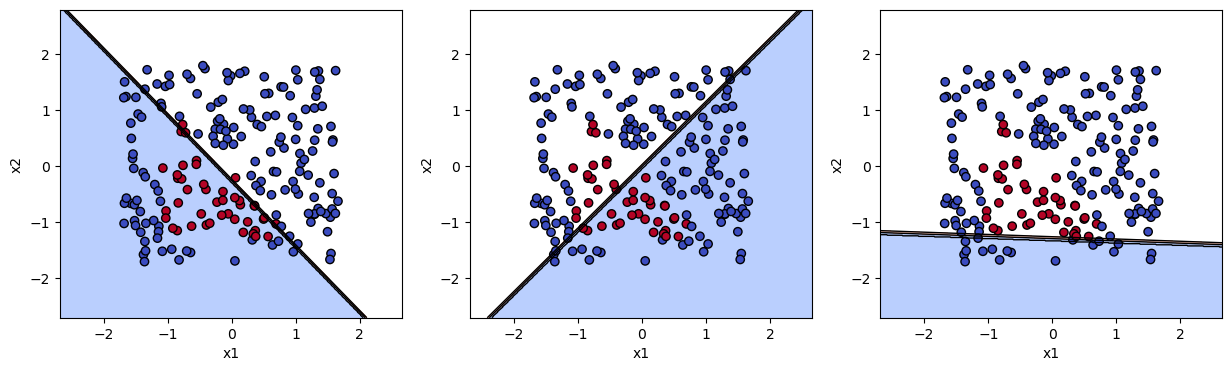

In [48]:
# Function to get hidden layer activations for any input
def get_hidden_activations(x):
    x_processed = preprocess_input(x)
    z1 = x_processed @ w[0] + b[0]  # Hidden layer pre-activation
    a1 = ReLU(z1)  # Hidden layer activation (3 neurons)
    return a1

# Plot decision boundary for each hidden neuron
h = 0.01  # step size in the mesh
x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                       np.arange(x2_min, x2_max, h))

# Create input grid
grid_input = np.c_[xx1.ravel(), xx2.ravel()]

# Get hidden layer activations for the grid
hidden_activations = get_hidden_activations(grid_input)

# Plot each hidden neuron's decision boundary
plt.figure(figsize=(15, 4))

for neuron_idx in range(3):  # 3 neurons in hidden layer
    plt.subplot(1, 3, neuron_idx + 1)
    
    # Get activation for this neuron
    Z_neuron = hidden_activations[:, neuron_idx]
    Z_neuron = Z_neuron.reshape(xx1.shape)
    
    # Plot the contour and training points
    plt.contourf(xx1, xx2, Z_neuron, levels=[0, 0.5, 1], cmap="coolwarm", alpha=0.6)
    plt.contour(xx1, xx2, Z_neuron,levels=[0, 0.5, 1], colors='black', linewidths=1) 
    plt.scatter(x[:, 0], x[:, 1], c=y.ravel(), edgecolors='k', cmap="coolwarm")
    plt.xlabel("x1")
    plt.ylabel("x2")


plt.show()


